# Causal Inference with Graphical Models

Broadly speaking, in causal inference, we are interested in using data from observational studies (as opposed to randomized control trials), in order to answer questions of the following form -- What is the (causal) effect, on some outcome(s) $Y$, of setting (possibly contrary to fact) some variable(s) $A$ to value(s) $a$, via an **intervention**. That is to say, causal inference concerns itself with the expression of counterfactual distributions obtained from observational distributions through the process of interventions. Causal effects are sometimes determined using RCTs, but these are often expensive or unethical -- think forcing a random portion of the population to smoke to determine the effect of smoking on lung cancer. The goal of causal inference then is to determine whether such causal effects can be teased out from purely observational data. When such counterfactual quantities can be written as functions of the observed data, they are said to be **identified**. Not all causal effects can be identified, but many can -- if we impose enough assumptions on the observed data distribution. Assumptions then, is the price we pay for identifiability, and so being transparent about our assumptions when making causal claims is paramount. This is where **graphical models** allow us to concisely, and intuitively state our set of assumptions. In the words of Miguel Hernán, "Graphical models allow us to draw our assumptions before our conclusions."

A graph ${\cal G}$ is defined by a set of vertices ${\bf V}$ and edges that could be directed (e.g., $X \rightarrow$ Y) interpreted as $X$ being a direct cause of $Y$, bidirected (e.g., $X \leftrightarrow Y$) interpreted as the existence of unmeasured common causes of both $X$ and $Y$ ($X \leftarrow {\bf U} \rightarrow Y$), or undirected (e.g., $X - Y$) interpreted as a symmetric relationship between $X$ and $Y$. In Ananke, we currently support acyclic graphical models i.e., we do not allow for cyclic causality. So how exactly do graphs help us encode assumptions? Consider the **Directed Acyclic Graph (DAG)** below.

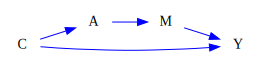

In [1]:
# imports for this notebook

from ananke import graphs
from ananke import identification

vertices = ['A', 'M', 'Y', 'C']
edges = [('A', 'M'), ('M', 'Y'), ('C', 'A'), ('C', 'Y')]
dag = graphs.DAG(vertices, edges)
# the direction LR is just to lay the vertices of the graph out from left to right
# instead of top to bottom which is the default
dag.draw(direction='LR')

All interventional distributions in causal models of a DAG are identified by application of the [**g-formula**](https://core.ac.uk/download/pdf/82537972.pdf). For example, $p(Y|{\rm do}(a))$ written as $p(Y(a))$ in potential outcomes notation which we will use more commonly here, is identified as $$p(Y(a))=\sum_{C, M}p(Y|M, C)p(M|A)p(C)|_{A=a}.$$ But as alluded to earlier, this comes at a price. The assumption made by a DAG (in addition to conditional independence constraints that can be read off by the graphical criterion of d-separation) is that of causal sufficiency, i.e., the absence of bidirected edges assumes the absence of unmeasured common causes. If we are unwilling to assume causal sufficiency, we can impose generalized independence constraints given by [Nested Markov models](https://arxiv.org/pdf/1701.06686.pdf) of an **Acyclic Directed Mixed Graph (ADMG)** representing marginals of DAG models. The ADMG corresponding to the scenario where $C$ is unobserved is shown below.

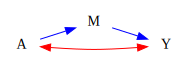

In [2]:
vertices = ['A', 'M', 'Y']
di_edges = [('A', 'M'), ('M', 'Y')]
bi_edges = [('A', 'Y')]
admg = graphs.ADMG(vertices, di_edges=di_edges, bi_edges=bi_edges)
admg.draw(direction='LR')

In this case $p(Y(a))$ is still identified but not all interventional distributions of an ADMG are identified. A sound and complete algorithm for identification in ADMGs is known due to [Tian and Pearl](http://new.aaai.org/Papers/AAAI/2002/AAAI02-085.pdf), and [Shpitser and Pearl](https://ftp.cs.ucla.edu/pub/stat_ser/r327.pdf). In Ananke, we use a purely [graphical formulation](https://arxiv.org/pdf/1701.06686.pdf) of the aforementioned works that uses the fixing operation ($\phi$) on nested Markov models, in order to answer identification queries (example below). Note that some work is still required for Ananke to produce a simplified identifying functional in terms of the original data distribution $p({\bf V})$.

In [3]:
outcomes = ['Y']
interventions = ['A']
id_pya = identification.OneLineID(graph=admg, interventions=interventions, outcomes=outcomes)
print('Identifed =', id_pya.id(), '; Functional =', id_pya.functional())

Identifed = True ; Functional = ΣM ΦAM(p(V);G) ΦAY(p(V);G) 


Another implicit assumption made in the above examples was that our data consisted of independent and identically distributed (iid) samples. **Chain Graphs (CGs)**, consisting of directed and undirected edges such that there are no partially directed cycles, have emerged as a popular graphical model of **interference** (a violation of the independence assumption). Consider a scenario in which our population consists of dyads (say couples) capable of influencing each others outcomes. This may be depicted as shown below.

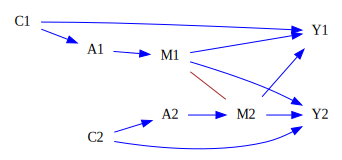

In [4]:
vertices = ['C1', 'A1', 'M1', 'Y1', 'C2', 'A2', 'M2', 'Y2']
di_edges = [('A1', 'M1'), ('M1', 'Y1'), ('C1', 'A1'), ('C1', 'Y1'),
            ('A2', 'M2'), ('M2', 'Y2'), ('C2', 'A2'), ('C2', 'Y2'),
            ('M1', 'Y2'), ('M2', 'Y1')]
ud_edges = [('M1', 'M2')]
cg = graphs.CG(vertices, di_edges=di_edges, ud_edges=ud_edges)
cg.draw(direction='LR')

All interventional distributions of a CG are identified by a [CG version](https://www.jstor.org/stable/pdf/3088778.pdf?refreqid=excelsior%3A8042bfde904f401034faca7093a951c9) of the g-formula. Note however, that chain graphs assume causal sufficiency (lack of bidirected edges). If we'd like to further relax this assumption, we use **Segregated Graphs (SGs)**. Once again, if we do not observe $C$s in the CG shown above, we obtain the SG below. A sound and complete algorithm for identification in SGs was provided by [Sherman and Shpitser](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6330046/pdf/nihms-1001697.pdf).

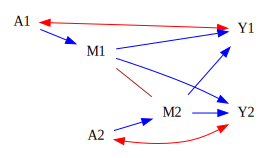

In [5]:
vertices = ['A1', 'M1', 'Y1', 'A2', 'M2', 'Y2']
di_edges = [('A1', 'M1'), ('M1', 'Y1'),
            ('A2', 'M2'), ('M2', 'Y2'),
            ('M1', 'Y2'), ('M2', 'Y1')]
ud_edges = [('M1', 'M2')]
bi_edges = [('A1', 'Y1'), ('A2', 'Y2')]
sg = graphs.SG(vertices, di_edges=di_edges, ud_edges=ud_edges, bi_edges=bi_edges)
sg.draw(direction='LR')

We end this section by providing a hierarchy of graphical models (shown below). Two of the models in this hierarchy -- bidirected graphs (BGs), and undirected graphs (UGs) are often not considered by themselves in causal analysis but are building blocks of more complicated graphical models that are, as reflected in the graph hierarchy. At the top of the hierarchy, are SGs comprised of directed, bidirected, and undirected edges. An SG with no undirected edges is an ADMG, and an SG with no bidirected edges is a CG. A BG is an ADMG with no directed edges, and a UG is a CG with no directed edges. Finally, a DAG is an ADMG with no bidirected edges _or_ alternatively a CG with no undirected edges. As we go further up in the hierarchy we relax more assumptions, but identification theory becomes trickier, and so does estimation. For example, a generalized likelihood for BGs, ADMGs, and SGs is not known.

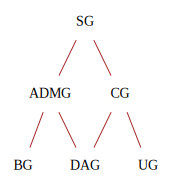

In [6]:
# a graph of the hierarchy of graphs
vertices = ['SG', 'ADMG', 'CG', 'DAG', 'BG', 'UG']
edges = [('SG', 'ADMG'), ('SG', 'CG'), ('ADMG', 'DAG'), ('CG', 'DAG'), ('ADMG', 'BG'), ('CG', 'UG')]
graphs.UG(vertices, edges).draw()